## Sentiment analysis

<img src="https://formtitanhelpdeskimage.s3.amazonaws.com/70c78f9df2fd5c130e7021644f78f4c5.jpg" alt="drawing" width="400"/>

In [1]:
import text_transformer as tt
remove_tokens = ["’", "‘", "would", "said", "also", "“", "”", "–"]
filter_words = ["Trump"]
%time articles, _ = tt.preprocessing(directory="articles", verbose= True, remove_words=remove_tokens, filter_words=filter_words)


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We're at 0.0% of the data.
We're at 6.12% of the data.
We're at 12.25% of the data.
We're at 18.37% of the data.
We're at 24.49% of the data.
We're at 30.62% of the data.
We're at 36.74% of the data.
We're at 42.86% of the data.
We're at 48.99% of the data.
We're at 55.11% of the data.
We're at 61.23% of the data.
We're at 67.36% of the data.
We're at 73.48% of the data.
We're at 79.6% of the data.
We're at 85.73% of the data.
We're at 91.85% of the data.
We're at 97.97% of the data.
Articles used: 13.4 %
Articles used: 2188/16331
*********************************************
3109  ( 19.04 %) Articles were filtered out because of length and language
11034  ( 67.56 %) Articles were filtered out because of the filter words.
CPU times: user 4min 22s, sys: 58.2 s, total: 5min 20s
Wall time: 5min 27s


In [2]:
!pip install nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(articles[0]["text"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.086, 'neu': 0.807, 'pos': 0.107, 'compound': 0.9394}

In [3]:
import pandas as pd

articles_df = pd.DataFrame.from_dict(articles)

In [4]:
#%%time
#articles_df["pos"] = articles_df.apply(lambda article: sia.polarity_scores(article["text"])["pos"], axis=1)
#articles_df["neg"] = articles_df.apply(lambda article: sia.polarity_scores(article["text"])["neg"], axis=1)
#articles_df["neu"] = articles_df.apply(lambda article: sia.polarity_scores(article["text"])["neu"], axis=1)
#articles_df["compound"] = articles_df.apply(lambda article: sia.polarity_scores(article["text"])["compound"], axis=1)



In [5]:
%%time

articles_df = articles_df.merge(articles_df.text.apply(lambda article: pd.Series(sia.polarity_scores(article))), 
    left_index=True, right_index=True)

CPU times: user 23.3 s, sys: 612 ms, total: 23.9 s
Wall time: 23.9 s


In [6]:
articles_df = articles_df.sort_values("neg", ascending=False)
articles_df = articles_df.reset_index(drop=True)

articles_df.head()

,author,newspaper,text,title,url,neg,neu,pos,compound
0,[Charlie Spiering],breitbart,White House Press Secretary Sarah Sanders shar...,Sarah Sanders Trolls Media with ‘Mueller Madne...,https://www.breitbart.com/politics/2019/03/25/...,0.308,0.623,0.069,-0.9927
1,[],foxnews,A lawyer for a man suspected of killing a repu...,Lawyer: Suspect in mob boss killing affected b...,https://www.foxnews.com/us/lawyer-suspect-in-m...,0.237,0.695,0.068,-0.9802
2,[Peter Baker],nytimes,WASHINGTON — President Trump went on the offen...,Trump Blames ‘Treasonous’ Critics for Russia I...,https://www.nytimes.com/2019/03/25/us/politics...,0.236,0.717,0.047,-0.9921
3,[Peter Baker],nytimes,WASHINGTON — President Trump went on the offen...,Trump Blames ‘Treasonous’ Critics for Russia I...,https://www.nytimes.com/2019/03/25/us/politics...,0.236,0.717,0.047,-0.9921
4,[],yahoo,NEW YORK (AP) — A lawyer for a man suspected o...,Lawyer: Suspect in mob boss killing affected b...,https://news.yahoo.com/man-arrested-reputed-yo...,0.232,0.701,0.067,-0.9802


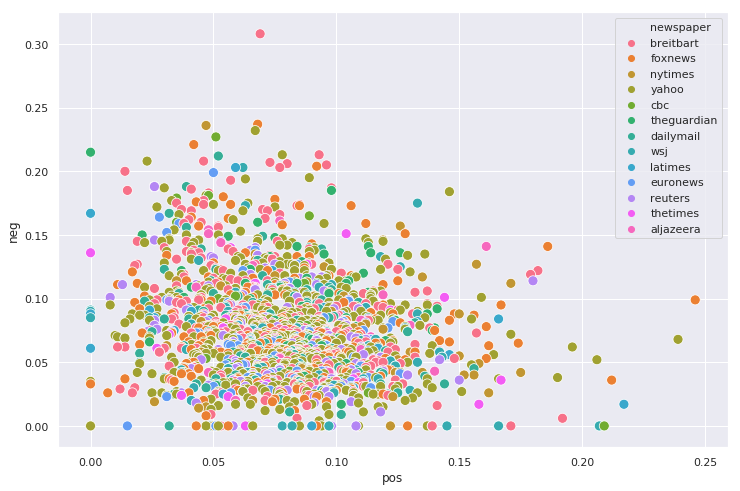

In [7]:
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=articles_df[~articles_df.newspaper.isin(["go","huffpost","washingtonpost","ft","nbcnews" ])],
                y="neg", x="pos", hue="newspaper", s=100)

<IPython.core.display.Javascript object>


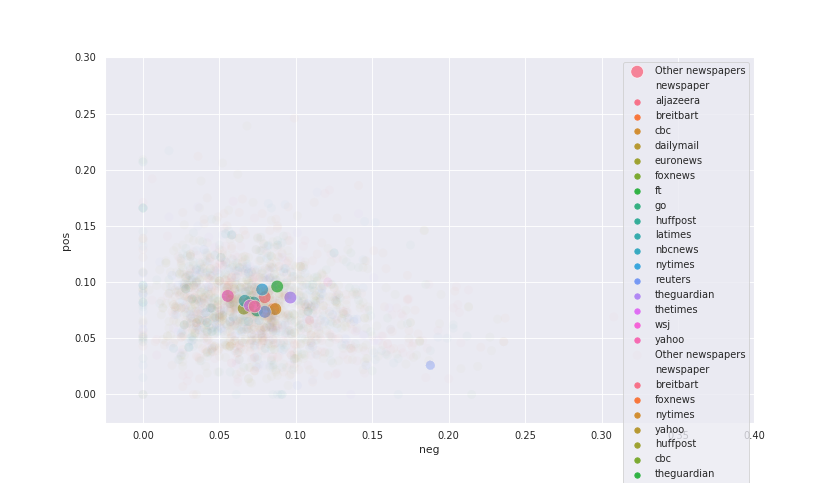

Box(children=(Dropdown(description='Newspaper:', index=17, options=('breitbart', 'foxnews', 'nytimes', 'yahoo'…

In [10]:
%matplotlib notebook
from ipywidgets import widgets
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

#Plot size
plt.figure(figsize=(13,7.5))
# Axis to be ploted, possible options neg, pos, neu and compound
y_axis="pos"
x_axis="neg"

#Ipython UI components
drop = widgets.Dropdown(
    options=np.append(articles_df.newspaper.unique(), [""]),
    description='Newspaper:',
    value=""
)
regression = widgets.Checkbox(False, description='Regression')
centroid = widgets.Checkbox(False, description='Centroid')


# Pre calculate the regressions for each newspaper
regressions = {newspaper: {} for newspaper in articles_df.newspaper.unique()}
reg = LinearRegression()
for newspaper in articles_df.newspaper.unique():
    reg_articles = articles_df[articles_df.newspaper.isin([newspaper])]
    reg.fit(reg_articles[x_axis].values.reshape(-1, 1) , reg_articles[y_axis])
    regressions[newspaper]["coef"] = reg.coef_
    regressions[newspaper]["intercept"] = reg.intercept_ 

    
#https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
# Ploting a regression line in matplotlib is strangly hard
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def action(words):
    plt.cla()
    ax=plt.gca()
    ax.set_xlim([-0.025,0.4])
    ax.set_ylim([-0.025,0.3])
    plot_alpha = 0.2
    selected_plot_alpha = 0.8
    centroid_alpha = 0.85
    selected_centroid_alpha = 1

    #Plot the centroids for all newspapers and lower transparency in the scatter
    if centroid.value:
        centers = articles_df.groupby("newspaper").mean().reset_index()
        sns.scatterplot(data=centers[~centers.newspaper.isin([drop.value])],
                        y=y_axis, x=x_axis, hue="newspaper", label="Other newspapers", 
                        s=200, alpha=centroid_alpha, ax=ax)
        sns.scatterplot(data=centers[centers.newspaper.isin([drop.value])], 
                        y=y_axis, x=x_axis, hue="newspaper", label="Selected Newspaper" 
                        ,alpha=selected_centroid_alpha, s=200, ax=ax)
        plot_alpha = 0.025
        selected_plot_alpha = 0.15

    #Plot pre computed regression for selected newspaper
    if regression.value and drop.value != "":
        abline(regressions[drop.value]["coef"], regressions[drop.value]["intercept"])
    
    #Plot the scatter plot
    sns.scatterplot(data=articles_df[~articles_df.newspaper.isin([drop.value])],
                    y=y_axis, x=x_axis, hue="newspaper", label="Other newspapers", 
                    s=100, alpha=plot_alpha, ax=ax)
    sns.scatterplot(data=articles_df[articles_df.newspaper.isin([drop.value])], 
                    y=y_axis, x=x_axis, hue="newspaper", label="Selected Newspaper" ,
                    s=100,alpha=selected_plot_alpha, ax=ax)
# Plot the inital plot
action(drop.value)

# Add actions to Ipython components
regression.observe(action)
centroid.observe(action)
drop.observe(
    lambda c: action(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)

# Display them after the plot
items = [item for item in [drop,regression,centroid]]
widgets.Box(items)
